In [76]:
import os
import re
import json
import numpy as np
import pandas as pd
from textwrap import wrap
from openai import OpenAI
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tqdm import tqdm

# Create new `pandas` methods which use `tqdm` progress
tqdm.pandas()

## Extract Annotated reviews:

In [88]:
df = pd.read_csv("../230418_GreatSchools_Revised_Annotated_Data.csv", low_memory=False)
df.head(3)

,Unnamed: 0,sch_ID,sch_name,sch_state,sch_county,status,sch_type,sch_level,sch_mean_ach,sch_grade_slope_mean_ach,...,L2_extracurricular/electives,L2_offering,L2_school finances,L2_family,L2_quality indicator,L2_teacher quality,L2_preparation,L2_postsecondary/graduation,L2_instruction,L2_curriculum/curricular materials
0,0,10000500870,Albertville Middle School,AL,MARSHALL COUNTY,1.0,tps,Middle,-0.331363,NaN,...,0,0,0,0,1,0,0,0,0,0
1,1,10000500871,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,1.0,tps,High,NaN,NaN,...,1,1,0,0,1,0,0,1,1,1
2,2,10000500871,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,1.0,tps,High,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [89]:
categories = [column.strip("L1_1") for column in df.columns if "L1" in column and "other" not in column]
# l2_vars = [column for column in df.columns if "L2" in column]
display(categories)

['school-level features',
 'physical environment',
 'instruction & learning',
 'school staff',
 'overall quality',
 'school culture',
 'resources']

## Extract Coded reviews

In [90]:
coded_reviews = pd.read_excel("../coded_reviews.xlsx", skiprows=1)
display(coded_reviews.head(3))
len(coded_reviews)

,reviewid,l1_instruction,l1_overallquality,l1_phyenvironment,l1_resources,l1_culture,l1_staff,l1_features,instruction,phyenvironment,resources,overallquality,culture,staff,features
0,101303,0,0,0,0,0,1,0,1,1,1,1,0,1,0
1,101508,1,1,0,1,1,1,0,1,0,1,1,0,1,0
2,102269,0,1,0,0,0,0,0,0,0,0,1,1,0,0


500

## Clean and Combine:


In [91]:
# Mapping from annotated data to coded reviews:

mapping = {
    # annotated_column : coded_column
    'L1_school-level features': 'features',
    'L1_physical environment': 'phyenvironment',
    'L1_instruction & learning': 'instruction',
    'L1_school staff': 'staff',
    'L1_overall quality': 'overallquality',
    'L1_school culture': 'culture',
    'L1_resources': 'resources'
}

In [96]:
annotated = df[ ["comments", "who", 
               "review_star_rating", "sch_name", "sch_state", 
               "sch_county", "sch_type"] + list(mapping.keys())].iloc[:500]

annotated = annotated.rename({column:"nlp_"+column.strip("L1_") for column in list(mapping.keys())}, axis=1)

coded = coded_reviews[ ['reviewid', 'instruction',
       'phyenvironment', 'resources', 'overallquality', 'culture', 'staff',
       'features', 'l1_instruction',
       'l1_phyenvironment', 'l1_resources', 'l1_overallquality', 'l1_culture', 'l1_staff',
       'l1_features'] ]

coded = coded.rename({
    'instruction': 'instruction & learning',
    'phyenvironment': 'physical environment',
    'resources': 'resources',
    'overallquality': 'overall quality',
    'culture': 'school culture',
    'staff': 'school staff',
    'features': 'school-level features',
    'l1_instruction': 'l1 instruction & learning',
    'l1_phyenvironment': 'l1 physical environment',
    'l1_resources': 'l1 resources',
    'l1_overallquality': 'l1 overall quality',
    'l1_culture': 'l1 school culture',
    'l1_staff': 'l1 school staff',
    'l1_features': 'l1 school-level features'
}, axis=1)

full_df = pd.merge(annotated, coded, left_index=True, right_index=True)
full_df.head(2)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,school culture,school staff,school-level features,l1 instruction & learning,l1 physical environment,l1 resources,l1 overall quality,l1 school culture,l1 school staff,l1 school-level features
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0,1,0,0,0,0,0,0,1,0
1,I attended Albertville High School my freshman...,student,2.0,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,tps,1,1,1,...,0,1,0,1,0,1,1,1,1,0


In [97]:
full_df.to_csv("full_df.csv", index=False)

## Call ChatGPT

In [93]:
import difflib

def match_column(column, column_names):
    closest_matches = difflib.get_close_matches(column, column_names, n=1, cutoff=0)
    # If we have at least one match, return the first one. Otherwise, return None.
    if closest_matches:
        return closest_matches[0]
    return None

In [20]:
client = OpenAI()

def clean(s):
    """Remove alphanumeric characters"""
    pattern = re.compile('[\W_]+')
    return pattern.sub('', s)

def get_gpt_pred(categories, comment, model="gpt-3.5-turbo", query=None):
    '''
    Calls ChatGPT API with given model and comment, returns series with predictons.
    Different models interpret the formatting aspect of the prompt differently, which can lead to unexpected errors.
    Raises error when formatting of response is not interpretable. 
    '''
    
    # formatting = 'Follow these instructions precisely. When provided with this input:\n {"content":content, "categories":categories} \
    #               determine which of the categories are discussed in the content, and always respond with a list of the following format\n ["category: 0 or 1" ...]'
    
    # query = f'"content":{comment},"content":{str(categories)}'
    if query==None:
        query = "Which of these topics: " + str(categories) + f'\n\nAre discussed in this review: "{comment}". For all topics, respond in the format: "topic": 0 or 1.'

    completion = client.chat.completions.create(
        model=model,
        messages=[
            # {"role":"user", "content":formatting},
            {"role":"user", "content":query}
        ],
        temperature=0.1, # creativity/randomness (lower is more deterministic, less random)
        top_p=0.1 # top token propbability mass (lower is restrictive)
    )
    response = completion.choices[0].message.content

    model_designation = model.split('-')[1]+"_"

    if "\n" in response:
        predictions = re.sub("[{}\"-]", "", response).split("\n")
    elif ", " in response:
        predictions = re.sub("[{}\"-]", "", response).split(", ")
    else:
        print(f"ERROR: could not find delimiter using model: {model}, here's the text:\n {response}")
        return pd.Series({model_designation+"output":response})

    try:
        # create series from dict of model+category and the predicted value, initialize fields to zero for when model selectively outputs.
        series = {model_designation+category:0 for category in categories}
        for prediction in predictions:
            if ': ' not in prediction:
                print("ERROR: response formatted incorrectly, no ':' in prediction (could be fluke)")
                continue
            column = model_designation+match_column(prediction.split(": ")[0], categories)
            series[column] = clean(prediction.split(": ")[1])
        series[model_designation+"output"] = predictions
    except Exception as e:
        print(f"ERROR: parsing failed. here's the exception:\n {e}\n\nhere's the text:\n {response}\n\nand here's the parsed text:\n {predictions}")
        return pd.Series({model_designation+"output":response})
    return pd.Series(series)


### Get 3.5 Responses:

In [9]:
# Get 3.5 predictions (using progress apply):
predictions_35_df = full_df["comments"].progress_apply(lambda x: get_gpt_pred(categories, x, "gpt-3.5-turbo"))
predictions_35_df.head(2)

  0%|          | 0/500 [00:00<?, ?it/s]

 31%|███▏      | 157/500 [04:21<05:08,  1.11it/s]  

ERROR: could not find delimiter using model: gpt-3.5-turbo, here's the text:
 "school staff": 1


 75%|███████▍  | 373/500 [10:31<01:55,  1.10it/s]  

ERROR: could not find delimiter using model: gpt-3.5-turbo, here's the text:
 "school staff": 1


100%|██████████| 500/500 [12:48<00:00,  1.54s/it]


,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output
0,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."
1,0,0,1,0,0,1,0,"[schoollevel features: 0, physical environment..."


In [10]:
final_df = pd.merge(full_df, predictions_35_df, left_index=True, right_index=True)
final_df.head(1)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,l1 school staff,l1 school-level features,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,1,0,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."


### Get 4.0 Responses:

In [11]:
# Get 4.0 predictions (using progress apply):
predictions_40_df = full_df["comments"].progress_apply(lambda x: get_gpt_pred(categories, x, "gpt-4"))
predictions_40_df.head(2)

 98%|█████████▊| 489/500 [17:49<00:21,  1.95s/it]

ERROR: parsing failed. here's the exception:
 list index out of range

here's the text:
 {
"school-level features": 0,
"physical environment": 0,
"instruction & learning": 1,
"school staff": 0,
"overall quality": 1,
"school culture": 0,
"resources": 1
}

and here's the parsed text:
 ['', 'schoollevel features: 0,', 'physical environment: 0,', 'instruction & learning: 1,', 'school staff: 0,', 'overall quality: 1,', 'school culture: 0,', 'resources: 1', '']


100%|██████████| 500/500 [18:11<00:00,  2.18s/it]


,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources,4_output
0,0,0,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
1,1,0,1,0,1,1,1,"[schoollevel features: 1, physical environment..."


In [12]:
final_df = pd.merge(final_df, predictions_40_df, left_index=True, right_index=True)
final_df.head(1)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,3.5_resources,3.5_output,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources,4_output
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0,"[schoollevel features: 0, physical environment...",0,0,1,1,1,1,0,"[schoollevel features: 0, physical environment..."


In [13]:
final_df.to_csv("full_dataset.csv", index=False)

In [3]:
final_df = pd.read_csv("full_dataset.csv")
display(final_df.head(2))
len(final_df)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,3.5_resources,3.5_output,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources,4_output
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0.0,"['schoollevel features: 0', 'physical environm...",0.0,0.0,1.0,1.0,1.0,1.0,0.0,"['schoollevel features: 0', 'physical environm..."
1,I attended Albertville High School my freshman...,student,2.0,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,tps,1,1,1,...,0.0,"['schoollevel features: 0', 'physical environm...",1.0,0.0,1.0,0.0,1.0,1.0,1.0,"['schoollevel features: 1', 'physical environm..."


500

In [5]:
nans = final_df[final_df[[column for column in final_df.columns if column != "review_star_rating" and column != "who"]].isna().any(axis=1)]
chat_gpt_predictions = [column for column in nans.columns if "3" in column or "4" in column]
nans[chat_gpt_predictions]

,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources,4_output
128,NaN,NaN,NaN,1.0,NaN,1.0,NaN,"['school staff: 1', 'school culture: 1']",0.0,0.0,1.0,1.0,0.0,1.0,0.0,"['schoollevel features: 0', 'physical environm..."
155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""school staff"": 1",0.0,0.0,1.0,1.0,1.0,1.0,0.0,"['schoollevel features: 0', 'physical environm..."
273,NaN,NaN,0.0,1.0,1.0,1.0,NaN,"['school staff: 1', 'instruction & learning: 0...",1.0,0.0,1.0,1.0,1.0,1.0,0.0,"['schoollevel features: 1,', 'physical environ..."
277,NaN,NaN,NaN,1.0,1.0,1.0,NaN,"['school staff: 1', 'school culture: 1', 'over...",1.0,0.0,0.0,1.0,1.0,1.0,0.0,"['schoollevel features: 1,', 'physical environ..."
309,NaN,NaN,NaN,1.0,1.0,1.0,NaN,"['school staff: 1', 'overall quality: 1', 'sch...",1.0,0.0,1.0,1.0,1.0,1.0,0.0,"['schoollevel features: 1,', 'physical environ..."
338,NaN,NaN,1.0,1.0,NaN,NaN,NaN,"['school staff: 1', 'instruction & learning: 1']",1.0,0.0,1.0,1.0,1.0,1.0,0.0,"['schoollevel features: 1', 'physical environm..."
371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""school staff"": 1",0.0,0.0,0.0,1.0,0.0,0.0,0.0,"['schoollevel features: 0', 'physical environm..."
405,NaN,NaN,NaN,1.0,1.0,NaN,1.0,"['school staff: 1', 'overall quality: 1', 'res...",0.0,0.0,0.0,1.0,1.0,0.0,0.0,"['schoollevel features: 0', 'physical environm..."
454,NaN,NaN,1.0,1.0,NaN,NaN,NaN,"['school staff: 1', 'instruction & learning: 1']",0.0,0.0,1.0,1.0,0.0,0.0,0.0,"['schoollevel features: 0', 'physical environm..."
487,0.0,0.0,1.0,0.0,0.0,0.0,1.0,"['schoollevel features: 0', 'physical environm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{\n""school-level features"": 0,\n""physical envi..."


In [6]:
# Remove all GPT fails:
def gpt_fails(x):
    if x[[column for column in nans.columns if "4" in column and "output" not in column]].isna().all():
        return True
    if x[[column for column in nans.columns if "3" in column and "output" not in column]].isna().all():
        return True
    return False

fails_index = nans[nans.apply(gpt_fails, axis=1)].index
fails_index # we expect 3 in most recent run

Index([155, 371, 487], dtype='int64')

In [7]:
final_df = final_df.drop(fails_index)
len(final_df)

497

In [8]:
# recode NaNs in chat_gpt columns to be 0:
final_df[chat_gpt_predictions] = final_df[chat_gpt_predictions].fillna(0)
final_df.to_csv("cleaned_full_dataset.csv", index=False)

TODO: False positive / false negative rate relative to human annotators per category
- Table/graph FP FN wrt human annotators
- Use keyword matching NLP thing from doc and check as well (high FP wrt humans)
- Find another dataset

In [2]:
final_df = pd.read_csv("cleaned_full_dataset.csv")
final_df.head(2)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,3.5_resources,3.5_output,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources,4_output
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0.0,"['schoollevel features: 0', 'physical environm...",0.0,0.0,1.0,1.0,1.0,1.0,0.0,"['schoollevel features: 0', 'physical environm..."
1,I attended Albertville High School my freshman...,student,2.0,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,tps,1,1,1,...,0.0,"['schoollevel features: 0', 'physical environm...",1.0,0.0,1.0,0.0,1.0,1.0,1.0,"['schoollevel features: 1', 'physical environm..."


In [3]:
sort_categories = ['school-level features',
 'physical environment',
 'instruction & learning',
 'school staff',
 'overall quality',
 'school culture',
 'resources']

coded = list(x[sort_categories])
gpt_35 = list(x[["3.5_"+cat for cat in sort_categories]])
gpt_40 = list(x[["4_"+cat for cat in sort_categories]])
nlp = list(x[["l1 "+cat for cat in sort_categories]])

In [51]:
from sklearn.metrics import jaccard_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Human coded:
coded = final_df[sort_categories]

# NLP model coded:
nlp_df = final_df[["l1 "+cat for cat in sort_categories]]

# ChatGPT 3.5 coded:
predictions_35_df = final_df[["3.5_"+cat for cat in sort_categories]]

# ChatGPT 4.0 coded: 
predictions_40_df = final_df[["4_"+cat for cat in sort_categories]]

In [6]:
coded.head()

,school-level features,physical environment,instruction & learning,school staff,overall quality,school culture,resources
0,0,1,1,1,1,0,1
1,0,0,1,1,1,0,1
2,0,0,0,0,1,1,0
3,0,1,0,1,1,1,0
4,0,0,1,1,0,1,0


In [7]:
nlp_df.head()

,l1 school-level features,l1 physical environment,l1 instruction & learning,l1 school staff,l1 overall quality,l1 school culture,l1 resources
0,0,0,0,1,0,0,0
1,0,0,1,1,1,1,1
2,0,0,0,0,1,0,0
3,0,0,0,1,1,1,0
4,0,0,0,1,1,0,0


In [8]:
predictions_35_df.head()

,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
predictions_40_df.head()

,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0


In [28]:
predictions = {
	"coded" : coded,
    "nlp_df" : nlp_df, 
    "predictions_40_df" : predictions_40_df, 
    "predictions_35_df" : predictions_35_df
}

In [85]:
metrics = {
	"jaccard_score" : jaccard_score, 
	"recall_score" : recall_score, 
	"precision_score" : precision_score, 
	"f1_score" : f1_score, 
	"accuracy_score" : accuracy_score
}

def confusion_matrix_passthrough(x):
	matrix = confusion_matrix(list(coded.iloc[x.name]), x, labels=[0, 1])
	tn, fp, fn, tp = matrix.ravel()
	return pd.Series({"tn":tn,"fp":fp,"fn":fn,"tp":tp,"confusion_matrix":matrix})

def metric_passthrough(x, metric_name, metric):
	return pd.Series({metric_name:metric(list(coded.iloc[x.name]), x)})

def compute_metrics(predictions):
	
	full_metrics = pd.DataFrame()
	
	for name, model_predictions in predictions.items():
		prediction_metrics = pd.DataFrame(index=range(len(model_predictions)))
		prediction_metrics["name"] = name
	
		# get confusion matrix vals:
		prediction_metrics = pd.merge(prediction_metrics, model_predictions.apply(confusion_matrix_passthrough, axis=1), left_index=True, right_index=True)
		
		for metric_name, metric in metrics.items():
			prediction_metrics = pd.merge(prediction_metrics, model_predictions.apply(lambda x: metric_passthrough(x, metric_name, metric), axis=1), left_index=True, right_index=True)
	
		full_metrics = pd.concat([full_metrics, prediction_metrics])
	return full_metrics

scored_predictions = compute_metrics(predictions)
display(scored_predictions)
scored_predictions.name.unique()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Li

,name,tn,fp,fn,tp,confusion_matrix,jaccard_score,recall_score,precision_score,f1_score,accuracy_score
0,coded,2,0,0,5,"[[2, 0], [0, 5]]",1.000000,1.000000,1.000000,1.000000,1.000000
1,coded,3,0,0,4,"[[3, 0], [0, 4]]",1.000000,1.000000,1.000000,1.000000,1.000000
2,coded,5,0,0,2,"[[5, 0], [0, 2]]",1.000000,1.000000,1.000000,1.000000,1.000000
3,coded,3,0,0,4,"[[3, 0], [0, 4]]",1.000000,1.000000,1.000000,1.000000,1.000000
4,coded,4,0,0,3,"[[4, 0], [0, 3]]",1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
492,predictions_35_df,2,1,1,3,"[[2, 1], [1, 3]]",0.600000,0.750000,0.750000,0.750000,0.714286
493,predictions_35_df,1,3,0,3,"[[1, 3], [0, 3]]",0.500000,1.000000,0.500000,0.666667,0.571429
494,predictions_35_df,3,1,1,2,"[[3, 1], [1, 2]]",0.500000,0.666667,0.666667,0.666667,0.714286
495,predictions_35_df,1,4,1,1,"[[1, 4], [1, 1]]",0.166667,0.500000,0.200000,0.285714,0.285714


array(['coded', 'nlp_df', 'predictions_40_df', 'predictions_35_df'],
      dtype=object)

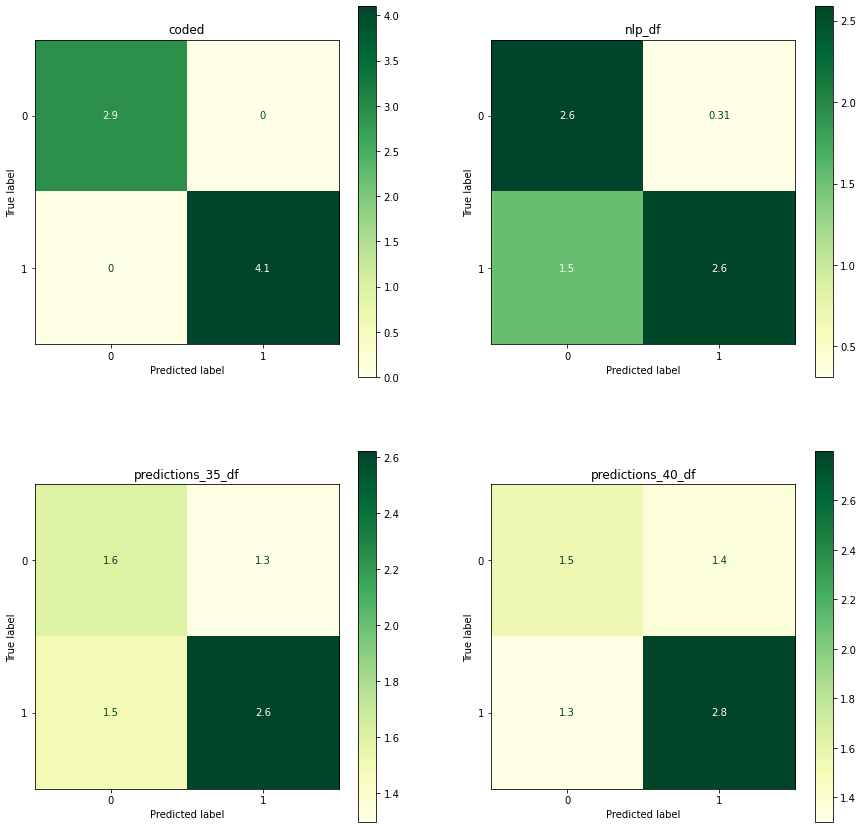

In [87]:
fig, axs = plt.subplots(figsize=(10, 10),ncols=1,nrows=2)
for model, ax in zip(means["name"].unique(), axs.ravel()):
	# means[means["name"]==model][["fn","fp","tn","tp"]].plot.bar(figsize=(10,10), title=model)
	matrix = means[means["name"]==model]["confusion_matrix"].iloc[0]
	ConfusionMatrixDisplay(confusion_matrix=matrix).plot(cmap="YlGn", ax=ax)
	ax.set_title(model)

In [102]:
means = scored_predictions.groupby("name").mean().reset_index()[['name','jaccard_score',
       'recall_score', 'precision_score', 'f1_score', 'accuracy_score']]
means

,name,jaccard_score,recall_score,precision_score,f1_score,accuracy_score
0,coded,0.995976,0.995976,0.995976,0.995976,1.000000
1,nlp_df,0.583252,0.623259,0.877005,0.704345,0.735844
2,predictions_35_df,0.479884,0.653679,0.672789,0.607320,0.603334
3,predictions_40_df,0.511953,0.692795,0.683396,0.647616,0.620868


# Takeways:

- NLP model is better at avoiding false positives
- Both GPT models have higher recall than the NLP model, leaving less categories  out
- It's possible that ChatGPT defaultly prioritizes recall
- Worth further tests (prompt_engineering.ipynb).

In terms of performance, we can see that the jaccard scores are somewhat comparable among all three models (NLP, 3.5, 4.0), but the difference really shows with precision and recall. GPTs are better at recall than the NLP model, labeling categories far more liberally. As a result, the NLP model is far more precise, and its f1 scores and accuracy scores are far better.

